# Predicting Online Credit Card Applications (Digital Advertising)
*Final Project #4: Modeling Performance*
<br>*Feb 5, 2017*

## Summary of Exploratory Data Analysis

During our EDA, we determined the following insights to guide us in developing our model:
* The event we are planning to predict is very rare:
    * **Conversions per User: 0.0130062273738 %**
* Most features had some positive correlation with our dependent variable, with the exception of the following features:
    * TimeDiff_Days_AVG (Average time between ad impressions)
    * Creative_Type_RichMediaExpanding_Imp
    * Some Creative Sizes
* **Correlated Features**: Many features are heavily correlated with each other. 
* **Outliers:** All of the features in our dataset have outliers at large values (e.g. a user shown more than 1000 impressions over 2 months).  When building our model, we will ignore any users that saw more the 3 standard deviations above the mean of impressions to avoid having outliers bias the model.

## Approach
We will take the follow steps to develop and tune our model:

* We will develop a classifier using **Logistic Regression**.  The reason for choosing this representation is mainly due to the need to develop intuitive explanations of the model to our end client (a non-technical audience).
* We will use **L1 regularization** to reduce the number of features in our model, especially because of many correlated features.
* Our scoring method will be **AUC (Area Under the Curve)**.  We chose AUC because the event we are predicting is rare.  We are adapting this scoring method based on how the medical field uses it to score the quality of signals for rare diseases.
* Finally, we will use our final model to calculate **ROI** and **Net Value** at difference thresholds of the predicted probabilities of our model that we classify a positive prediction.  We will identify the threshold that maximizes **Net Value**.
* Due to the very large size of our dataset, we plan to use a 20% random sample for developing our model.

## Define Business Performance Metrics

While we will use AUC to evaluate the quality of our models, we also want to caclulate business performance metrics of **ROI** and **Net Value**, as defined below.  Our focus will be to increase **Net Value** from an ad campaign, but we will also calculate ROI for reference.

To calculate these metrics, we need define how we will interpret the confusion matrix:

|True Class: Positive|True Class: Negative
------------------------------|:-------------:|:-------------:
**Predicted Class: Positive** |True Positives |False Positives
**Predicted Class: Negative** |False Negatives|True Negatives

Since we plan to use our model to predict how we should design our ad campaigns, we can interpret the predicted class to help us identify whether or not we'd like to reach users with a similar ad exposure:
* Positive Predicted Class: Spend on user because of high likelihood to convert
* Negative Predicted Calls: **Do not** spend on user
For example, if we predict a positive class for an observation in our dataset that was reached by 10 video ads and 15 display ads, we would plan on spending on similar users like this in the future.

Based on this interpretation, we can develop a cost-benefit methodology based on the confusion matrix:

|True Class: Positive|True Class: Negative
-----------------------------|:------------------------------------------:|:-------------:
**Predicted Class Positive** |Application Value<br>- Cost of Reaching User|-Cost of Reaching User
**Predicted Class Negative** |0|0
**Assumptions:**
* **ApplicationValue** = \$500 (The average value of a credit card application)
* **ReachCost** = \$0.033827 (The average cost of reaching a single user for our campaign)


Using this interpretation allows us to define the following **ROI** and **Net Value** functions:

\begin{equation*}
ROI = \frac{Total Value}{Total Cost} - 1
\end{equation*}

\begin{equation*}
Net Value = Total Value - Total Cost
\end{equation*}

\begin{equation*}
Total Value = ApplicationValue * TP
\end{equation*}

\begin{equation*}
Total Cost = ReachCost * (TP + FP)
\end{equation*}

Once we have determined our best estimator with AUC and `gridsearchsv`, we can then tune our **threshold** for a postive signal based on the predicted probability from our logistic regression model.  We will tune the **threshold** to maximize **Net Value**.

## Important Data and Data Cleaning

In [2]:
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sk_modelcurves.learning_curve import draw_learning_curve
from sklearn.metrics import roc_curve, auc
%matplotlib inline

In [3]:
data = pd.read_csv('../data/DATA_FOR_MODEL_20perc.csv', sep=',')
#data = pd.read_csv('../data/DATA_FOR_MODEL_FULL.csv', sep=',')
data.head(10)

,User_ID,Impressions,TimeDiff_Minutes,TimeDiff_Minutes_AVG,Funnel_Upper_Imp,Funnel_Middle_Imp,Funnel_Lower_Imp,Campaign_Message_Travel_Imp,Campaign_Message_Service_Imp,Campaign_Message_Family_Travel_Imp,...,Creative_Size_320x480_Imp,Creative_Size_Uknown_Imp,Device_Desktop_Imp,Device_Other_Imp,Device_Mobile_Imp,Active_View_Eligible_Impressions,Active_View_Measurable_Impressions,Active_View_Viewable_Impressions,Clicks,Conversions
0,AMsySZYlP3l94iys9P9WaBXIWE6B,3,2.0,1.000000,0,3,0,0,3,0,...,0,0,0,0,3,0,0,0,NaN,NaN
1,AMsySZbdCy7kK0BqCq38AvgzDJ7y,3,1.0,0.500000,0,3,0,3,0,0,...,0,0,3,0,0,3,3,1,NaN,NaN
2,AMsySZbsx0jjk_iOfpRCVx2ss3v8,2,12.0,12.000000,0,2,0,0,0,0,...,0,0,2,0,0,2,2,1,NaN,NaN
3,AMsySZZnAR-zSA0aCGVZkfhupUhU,5,23033.0,5758.250000,0,5,0,0,0,0,...,0,0,0,0,5,5,5,5,NaN,NaN
4,AMsySZb1yHw6ewPTnb7h39vBdCh8,2,188.0,188.000000,0,2,0,0,0,0,...,0,0,2,0,0,2,2,1,NaN,NaN
5,AMsySZbMUcclS_w01crSZ23CgZsa,1,NaN,NaN,0,1,0,0,0,0,...,0,0,0,0,1,1,1,0,NaN,NaN
6,AMsySZbN3U0Y-dpMwJBHb5KWpB6S,444,73303.0,165.469526,0,85,359,283,161,0,...,0,85,444,0,0,359,359,314,NaN,NaN
7,AMsySZZYbLJhgekE6XQ52ea1bpKb,2,80.0,80.000000,0,2,0,0,0,0,...,0,0,2,0,0,2,2,1,NaN,NaN
8,AMsySZaWJ0IyUoZmTqnYg4_LsylU,1,NaN,NaN,0,1,0,0,0,0,...,0,0,1,0,0,1,1,0,NaN,NaN
9,AMsySZbQxjkNdQtKIjG1m3fso1u_,9,56231.0,7028.875000,0,9,0,0,0,0,...,0,0,0,0,9,7,7,3,NaN,NaN


## Handle Missing Data

In [4]:
# For Clicks,Conversion, convert NULL values to zero
data['Clicks'].fillna(value=0,inplace=True)
data['Conversions'].fillna(value=0,inplace=True)

# Create a new categorical feature Converted, which will be 1 if the the user converted at least once, 
# and 0 if the user did not convert.
data['Converted'] = pd.Categorical([1 if x>0 else 0 for x in data['Conversions']])

# For TimeDiff_Minutes and TimeDiff_AVG, it is NULL when we only have 1 impression
# For now, replace with the median value and then add columns flagging the rows where we did this
# We will explore other options for handling this data in the feature engineering section
data['TimeDiff_NULL_FLAG'] = pd.Categorical(data['TimeDiff_Minutes'].isnull())

data['TimeDiff_Minutes'].fillna(value=data['TimeDiff_Minutes'].median(),inplace=True)
data['TimeDiff_Minutes_AVG'].fillna(value=data['TimeDiff_Minutes_AVG'].median(),inplace=True)

In [5]:
# confirm not nulls left dataset
data.isnull().sum()

User_ID                                 0
Impressions                             0
TimeDiff_Minutes                        0
TimeDiff_Minutes_AVG                    0
Funnel_Upper_Imp                        0
Funnel_Middle_Imp                       0
Funnel_Lower_Imp                        0
Campaign_Message_Travel_Imp             0
Campaign_Message_Service_Imp            0
Campaign_Message_Family_Travel_Imp      0
Campaign_Card_Cash_Rewards_Imp          0
Campaign_Card_Premium_Rewards_Imp       0
Campaign_Card_Other_Imp                 0
Creative_Type_Display_Imp               0
Creative_Type_TrueView_Imp              0
Creative_Type_RichMediaExpanding_Imp    0
Creative_Type_RichMedia_Imp             0
Creative_Size_728x90_Imp                0
Creative_Size_300x600_Imp               0
Creative_Size_300x250_Imp               0
Creative_Size_160x600_Imp               0
Creative_Size_468x60_Imp                0
Creative_Size_300x50_Imp                0
Creative_Size_320x50_Imp          

In [6]:
#Show the distribution of impressions (should affect all other rows features based on exploratory analysis)
data['Impressions'].describe()

count    3.036639e+06
mean     4.895185e+00
std      1.600795e+01
min      1.000000e+00
25%      1.000000e+00
50%      2.000000e+00
75%      3.000000e+00
max      5.600000e+03
Name: Impressions, dtype: float64

In [7]:
#Remove outliers (users with more than ~50 impressions, 3 standard devs above the mean of 4.9 impressions)
print max(data['Impressions'])
data = data[data['Impressions']<=50]
print max(data['Impressions'])

5600
50


In [8]:
X=data.drop(['User_ID','Conversions','Converted'],axis=1)
y=data['Converted']

In [9]:
# Split into Train/Test 
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=7)

## Business Performance Functions and Baseline Benchmark

In [10]:
# Define ROI function
# *See section "Define Business Performance Metrics" for more details
def ROI(y,y_pred,app_value,avg_user_cost):
    tn, fp, fn, tp = confusion_matrix(y_true=y, y_pred=y_pred).ravel()
    
    total_value=float(tp*app_value)
    total_cost=float((tp+fp)*avg_user_cost)
    ROI=total_value/total_cost-1
    
    return ROI

In [11]:
# Define New Value function
# *See section "Define Business Performance Metrics" for more details
def Net_Value(y,y_pred,app_value,avg_user_cost):
    tn, fp, fn, tp = confusion_matrix(y_true=y, y_pred=y_pred).ravel()
    
    total_value=float(tp*app_value)
    total_cost=float((tp+fp)*avg_user_cost)
    Net_Value=total_value-total_cost
    
    return Net_Value

#### Basline Performance
Get baseline performance by assuming our classified producted "1" (or "positive") for all of our dataset observations.
**NOTE:** Baseline benchmark should be calculated on test dataset.

In [12]:
# Assumptions:
#    Value of credit card application=$500
#    Avg cost of reaching a user=$0.033827
ROI_benchmark = ROI(y=y_test,
                    y_pred=np.ones(y_test.size),
                    app_value=500,
                    avg_user_cost=0.033827)
Net_Value_benchmark = Net_Value(y=y_test,
                                y_pred=np.ones(y_test.size),
                                app_value=500,
                                avg_user_cost=0.033827)

In [13]:
print "Baseline Net Value: {0:.0f}".format(Net_Value_benchmark)
print "Baseline ROI: {0:.1f}%".format(ROI_benchmark*100)

Baseline Net Value: 15690
Baseline ROI: 77.3%


## L1 Logistic Regression - All Existing Features

Use L1 regularization with Logistic Regression to Identify Important/Non-Important features

In [14]:
# Standardization: bring all of our features onto the same scale
stdsc = StandardScaler()
X_train_std = stdsc.fit_transform(X_train)
X_test_std = stdsc.transform(X_test)

In [15]:
# Cross-validation: 5 cross validation iterations with 30% test / 70% train
cv = ShuffleSplit(n_splits=5, test_size=0.3, random_state=0)

In [16]:
%%time
logregL1 = LogisticRegression(penalty='l1')
parameters = {'C': [0.001,0.05,0.1,0.3,0.5]}
clf = GridSearchCV(logregL1, parameters, cv=cv,scoring="roc_auc")
clf.fit(pd.DataFrame(X_train_std), pd.Series(y_train))   #turning into pandas dataframe or series prevents an error

CPU times: user 20min 13s, sys: 44.4 s, total: 20min 58s
Wall time: 20min 17s


In [17]:
print "Best model parameters are: {}".format(clf.best_params_)
print "Best AUC model score is: {}".format(clf.best_score_)

Best model parameters are: {'C': 0.05}
Best AUC model score is: 0.731114239221


**Notes**
* **AUC of 0.7311** is "Fair" quality model
* Good start, but we will see if can improve this score with some new features
* Before that, we will:
    * Review the current model coefficients
    * Plot distribution of predicted probabilities
    * Plot the ROC against the Test data for reference

#### Show Coefficients

In [18]:
best_logreg = clf.best_estimator_

In [19]:
# Look at coefficients that are zero
#lgl1_coeff = pd.DataFrame(zip(X.columns,logreg.coef_),columns=['Features','Coefficients'])
best_coeff=pd.DataFrame({'Features':X.columns,
                         'Coefficients':best_logreg.coef_[0]})

In [20]:
# Show non-important / zero'd features
best_coeff[best_coeff['Coefficients']==0]

,Coefficients,Features
0,0.0,Impressions
2,0.0,TimeDiff_Minutes_AVG
3,0.0,Funnel_Upper_Imp
6,0.0,Campaign_Message_Travel_Imp
7,0.0,Campaign_Message_Service_Imp
12,0.0,Creative_Type_Display_Imp
13,0.0,Creative_Type_TrueView_Imp
14,0.0,Creative_Type_RichMediaExpanding_Imp
15,0.0,Creative_Type_RichMedia_Imp
16,0.0,Creative_Size_728x90_Imp


In [36]:
#Show important features
kept_coeff=best_coeff[best_coeff['Coefficients']!=0]
kept_coeff

,Coefficients,Features
1,0.064708,TimeDiff_Minutes
4,-0.396872,Funnel_Middle_Imp
5,0.054886,Funnel_Lower_Imp
8,0.085195,Campaign_Message_Family_Travel_Imp
9,0.006758,Campaign_Card_Cash_Rewards_Imp
10,-0.049589,Campaign_Card_Premium_Rewards_Imp
11,0.021682,Campaign_Card_Other_Imp
22,-0.042016,Creative_Size_320x50_Imp
23,0.006210,Creative_Size_320x420_Imp
27,0.129454,Device_Desktop_Imp


#### Draw Learning Curve

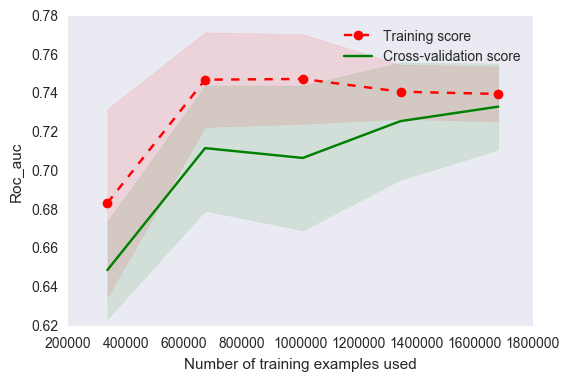

In [122]:
%%time
draw_learning_curve(best_logreg, pd.DataFrame(X_train_std), pd.Series(y_train), scoring='roc_auc', cv=cv);

**Notes:**
* The flattening of the training score curve shows we likely would not get more value from more data
* We do see the variance of the cross-validation score increase which could lead to overfitting
* We also have some Bias as the training set only reaches ~.76 AUC, whic indicates that we could improve the model with additional features.

#### Plot distribution of Predicted Probabilities

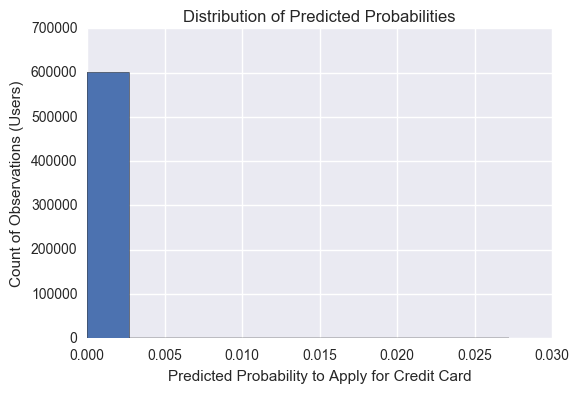

In [44]:
#Distribution of predictions
y_probs = best_logreg.predict_proba(X_test_std)[:,1]
plt.hist(y_probs)
plt.title("Distribution of Predicted Probabilities")
plt.xlabel("Predicted Probability to Apply for Credit Card")
plt.ylabel("Count of Observations (Users)");

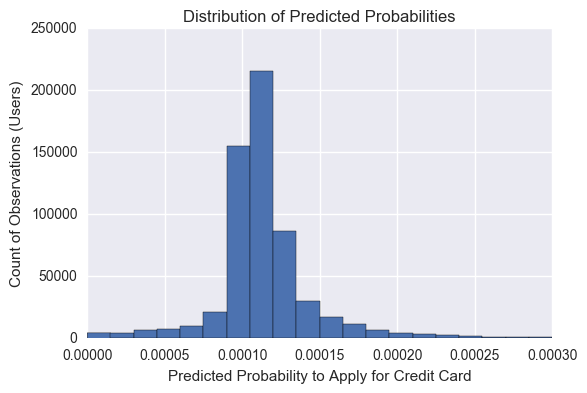

In [45]:
#Distribution of predictions (Zoom in at probabilites<0.03%)
max_in_chart=0.0003
plt.hist(y_probs[y_probs<max_in_chart],bins=20);
plt.title("Distribution of Predicted Probabilities")
plt.xlabel("Predicted Probability to Apply for Credit Card")
plt.ylabel("Count of Observations (Users)");

**Notes**
* The large peak in the middle is an indication of how how hard it is to distinquish our observations from each other
* However, there is a long tail to the right as seen in the first graph

#### Plot ROC/AUC on Test Dataset (Reference Point)

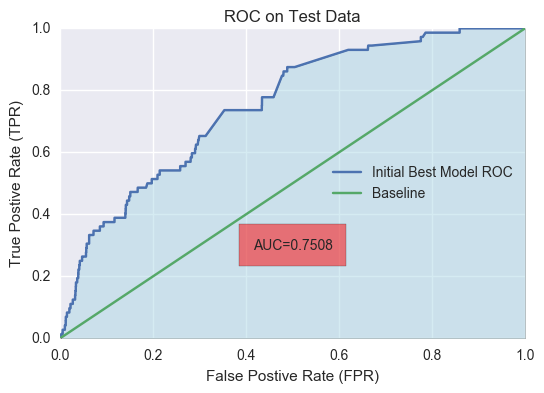

In [46]:
#Plot ROC
fpr, tpr, thresholds = roc_curve(y_test, y_probs)
plt.plot(fpr,tpr,label='Initial Best Model ROC')

#Plot reference line
z=np.linspace(0,1,20)
plt.plot(z,z,label='Baseline');

#Calculate AUC
area=auc(fpr, tpr)
plt.text(0.5, 0.3, 'AUC={0:0.4f}'.format(area), style='normal',
         verticalalignment='center', horizontalalignment='center',
         bbox={'facecolor':'red', 'alpha':0.5, 'pad':10})

# AUC shading
x = np.linspace(0.0, 1, 11)
plt.fill_between(fpr, 0, tpr, where=tpr >= 0, facecolor='lightblue', interpolate=True,alpha=0.5)

#Plot details
plt.title("ROC on Test Data")
plt.xlabel("False Postive Rate (FPR)")
plt.ylabel("True Postive Rate (TPR)")
plt.legend(loc='right');

**Notes**
* AUC slightly improve from 0.7311 (Training Data cross-validation) to 0.7508 on the Test Data
* We will keep this as a reference point to try to improve by adding new features in the next section

## Try New Features

1. Funnel Halo Effect
2. Categorical for Time Diff
3. Percent Viewable Impressions
4. Combined Creative Sizes in Small, Medium, Large

### 1. Funnel Halo Effect
We believe there is a potential halo effect from being reached by multiple stages of the marketing funnel.  Therefore, we will create 4 new features to capture these overlaps in ad exposure:
* Upper_and_Lower
* Upper_and_Middle
* Middle_Lower
* Upper_Middle_Lower

In [133]:
# Create new features
data['Upper_and_Lower'] = data['Funnel_Upper_Imp']*data['Funnel_Lower_Imp']
data['Upper_and_Middle'] = data['Funnel_Upper_Imp']*data['Funnel_Middle_Imp']
data['Middle_Lower'] = data['Funnel_Middle_Imp']*data['Funnel_Lower_Imp']
data['Upper_Middle_Lower'] = data['Funnel_Upper_Imp']*data['Funnel_Middle_Imp']*data['Funnel_Lower_Imp']

In [145]:
# Re-prepare the Features dataset
# Keep only the features we found are important in our L1 regularization in our first model
# Add new features
features=kept_coeff['Features'].tolist() + ['Upper_and_Lower','Upper_and_Middle','Middle_Lower','Upper_Middle_Lower']
X=data[features]

# Split into Train/Test (random state ensures same breakdown)
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=7)

# Standardization: bring all of our features onto the same scale
X_train_std = stdsc.fit_transform(X_train)
X_test_std = stdsc.transform(X_test)

In [146]:
%%time
logregL1 = LogisticRegression(penalty='l1')
parameters = {'C': [0.001,0.05,0.1,0.3,0.5]}
clf = GridSearchCV(logregL1, parameters, cv=cv,scoring="roc_auc")
clf.fit(pd.DataFrame(X_train_std), pd.Series(y_train))   #turning into pandas dataframe or series prevents an error

CPU times: user 8min 36s, sys: 27.6 s, total: 9min 4s
Wall time: 8min 24s


In [147]:
print "Best model parameters are: {}".format(clf.best_params_)
print "Best AUC model score is: {}".format(clf.best_score_)

Best model parameters are: {'C': 0.05}
Best AUC model score is: 0.733026754188


In [152]:
best_coeff=pd.DataFrame({'Features':X.columns,
                         'Coefficients':clf.best_estimator_.coef_[0]})
best_coeff

,Coefficients,Features
0,0.064403,TimeDiff_Minutes
1,-0.399255,Funnel_Middle_Imp
2,0.052844,Funnel_Lower_Imp
3,0.084410,Campaign_Message_Family_Travel_Imp
4,0.005709,Campaign_Card_Cash_Rewards_Imp
5,-0.050107,Campaign_Card_Premium_Rewards_Imp
6,0.021560,Campaign_Card_Other_Imp
7,-0.041603,Creative_Size_320x50_Imp
8,0.006205,Creative_Size_320x420_Imp
9,0.134881,Device_Desktop_Imp


**Notes**
* Small improvement in AUC from 0.7311 tot 0.7330
* Minimual Improvemnt to AUC and the only "Upper_and_Lower" added, perhaps not worth adding to model

### 2. Alternative Time-Difference Feature
Change Time-Difference Feature to be categorical, with the following breakouts
* **Only One Impression:** User only received 1 impression (use this category as the reference point, don't include in mode)
* **TimeDiff_One_Day:** Mulitple Impressions in one day
* **TimeDiff_1to7_Days:** Mulitple Impressions in one week (but more than a single day)
* **TimeDiff_7plus:** Multiple Impressions over several days (more than one week)

In [47]:
# Create new features
data['TimeDiff_One_Day'] = pd.Categorical( (data['Impressions']>1) &
                                           (data['TimeDiff_Minutes']<= (24*60)) ) 
data['TimeDiff_1to7_Days'] = pd.Categorical( (data['Impressions']>1) &
                                             (data['TimeDiff_Minutes']> (24*60)) & 
                                            (data['TimeDiff_Minutes']<= (24*60*7)) )
data['TimeDiff_7plus'] = pd.Categorical( (data['Impressions']>1) &
                                             (data['TimeDiff_Minutes']> (24*60*7)) )

In [50]:
data[['Impressions','TimeDiff_Minutes','TimeDiff_One_Day','TimeDiff_1to7_Days','TimeDiff_7plus']].sample(10)

,Impressions,TimeDiff_Minutes,TimeDiff_One_Day,TimeDiff_1to7_Days,TimeDiff_7plus
1449060,1,1481.0,False,False,False
1181194,9,4608.0,False,True,False
2269738,1,1481.0,False,False,False
1946283,1,1481.0,False,False,False
2030945,3,8884.0,False,True,False
2775876,2,1.0,True,False,False
3015205,1,1481.0,False,False,False
1604817,4,211.0,True,False,False
1870112,1,1481.0,False,False,False
2728273,15,64870.0,False,False,True


In [51]:
# Re-prepare the Features dataset
# Keep only the features we found are important in our L1 regularization in our first model
# Replace time features with new ones
features=kept_coeff['Features'].tolist() + ['TimeDiff_One_Day','TimeDiff_1to7_Days','TimeDiff_7plus'] 
X=data[features]
X=X.drop(['TimeDiff_Minutes','TimeDiff_NULL_FLAG'],axis=1)

# Split into Train/Test (random state ensures same breakdown)
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=7)

# Standardization: bring all of our features onto the same scale
X_train_std = stdsc.fit_transform(X_train)
X_test_std = stdsc.transform(X_test)

In [52]:
%%time
logregL1 = LogisticRegression(penalty='l1')
parameters = {'C': [0.001,0.05,0.1,0.3,0.5]}
clf = GridSearchCV(logregL1, parameters, cv=cv,scoring="roc_auc")
clf.fit(pd.DataFrame(X_train_std), pd.Series(y_train))   #turning into pandas dataframe or series prevents an error

CPU times: user 7min 3s, sys: 26.2 s, total: 7min 29s
Wall time: 6min 52s


In [53]:
print "Best model parameters are: {}".format(clf.best_params_)
print "Best AUC model score is: {}".format(clf.best_score_)

Best model parameters are: {'C': 0.1}
Best AUC model score is: 0.727869693493


In [54]:
best_coeff=pd.DataFrame({'Features':X.columns,
                         'Coefficients':clf.best_estimator_.coef_[0]})
best_coeff

,Coefficients,Features
0,-0.688399,Funnel_Middle_Imp
1,0.013938,Funnel_Lower_Imp
2,0.207509,Campaign_Message_Family_Travel_Imp
3,0.070059,Campaign_Card_Cash_Rewards_Imp
4,-0.057239,Campaign_Card_Premium_Rewards_Imp
5,0.023785,Campaign_Card_Other_Imp
6,-0.122755,Creative_Size_320x50_Imp
7,0.009637,Creative_Size_320x420_Imp
8,0.139749,Device_Desktop_Imp
9,-0.291493,Device_Other_Imp


**Notes**
* AUC slightly worsened from 0.7311 to 0.7278 (minimal difference)
* This representation is slightly more intuitive, perhaps keep this one.

### 3. Percent of Impressions Viewable
We believe that the percent of impressions shown that were viewable could potentially be an important feature.  Viewable_Percent will be defined as:

\begin{equation*}
ViewablePercent = \frac{ViewableImpressions}{MeasurableImpressions}
\end{equation*}

In [78]:
# Create new features
data['Viewable_Percent'] = data['Active_View_Viewable_Impressions'] / data['Active_View_Measurable_Impressions']

# Replace NULL/inf with zero (penalizes causes where no impressions were measureable)
data['Viewable_Percent'].fillna(0,inplace=True)
data['Viewable_Percent']=data['Viewable_Percent'].replace(np.inf,0)

# Some data issues may cause negative values or values above 1
# For negative values, change to 0
# For values above 1, change to 1
data['Viewable_Percent']=[0 if x<0 else x for x in data['Viewable_Percent']]
data['Viewable_Percent']=[1 if x>1 else x for x in data['Viewable_Percent']]

In [79]:
print max(data['Viewable_Percent'])
print min(data['Viewable_Percent'])

1.0
0.0


In [80]:
data[['Active_View_Viewable_Impressions','Active_View_Measurable_Impressions','Viewable_Percent']].sample(5)

,Active_View_Viewable_Impressions,Active_View_Measurable_Impressions,Viewable_Percent
2724085,0,0,0.0
2648956,2,4,0.5
1896920,4,8,0.5
2046039,6,20,0.3
2202346,1,1,1.0


In [81]:
# Re-prepare the Features dataset
# Keep only the features we found are important in our L1 regularization in our first model
# Replace time features with new ones
features=kept_coeff['Features'].tolist() + ['Viewable_Percent'] 
X=data[features]

# Split into Train/Test (random state ensures same breakdown)
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=7)

# Standardization: bring all of our features onto the same scale
X_train_std = stdsc.fit_transform(X_train)
X_test_std = stdsc.transform(X_test)

In [82]:
%%time
logregL1 = LogisticRegression(penalty='l1')
parameters = {'C': [0.001,0.05,0.1,0.3,0.5]}
clf = GridSearchCV(logregL1, parameters, cv=cv,scoring="roc_auc")
clf.fit(pd.DataFrame(X_train_std), pd.Series(y_train))   #turning into pandas dataframe or series prevents an error

CPU times: user 5min 50s, sys: 25.1 s, total: 6min 15s
Wall time: 6min 15s


In [83]:
print "Best model parameters are: {}".format(clf.best_params_)
print "Best AUC model score is: {}".format(clf.best_score_)

Best model parameters are: {'C': 0.05}
Best AUC model score is: 0.733110067906


In [87]:
best_coeff=pd.DataFrame({'Features':X.columns,
                         'Coefficients':clf.best_estimator_.coef_[0]})
best_coeff

,Coefficients,Features
0,0.064722,TimeDiff_Minutes
1,-0.396829,Funnel_Middle_Imp
2,0.054921,Funnel_Lower_Imp
3,0.085190,Campaign_Message_Family_Travel_Imp
4,0.006752,Campaign_Card_Cash_Rewards_Imp
5,-0.049593,Campaign_Card_Premium_Rewards_Imp
6,0.021681,Campaign_Card_Other_Imp
7,-0.042019,Creative_Size_320x50_Imp
8,0.006210,Creative_Size_320x420_Imp
9,0.129397,Device_Desktop_Imp


**Notes:**
* The new feature did not make it past regularization

### 4. Alternative Creative Size Representation
Instead of using each creative as a feature, we can represent the creatives by Small,Medium, and Large. Create two new features as the **summation** of other creative size features.  We are using summation because each feature represents the impresions from that creative size, so if we group them together, we can sum the impressions.

* **Small Creative Sizes:**
    * Creative_Size_300x50_Imp
    * Creative_Size_320x50_Imp
    * Creative_Size_468x60_Imp
* **Medium Creative Sizes:**
    * Creative_Size_160x600_Imp
    * Creative_Size_300x250_Imp
    * Creative_Size_728x90_Imp
* **Large Creative Sizes:**
    * Creative_Size_300x600_Imp
    * Creative_Size_320x420_Imp
    * Creative_Size_320x480_Imp
    * Creative_Size_480x320_Imp
* **Creative_Size_Uknown_Imp**

In [123]:
# Create new features
data['Creative_Small'] = data['Creative_Size_300x50_Imp'] + data['Creative_Size_468x60_Imp'] \
                        +data['Creative_Size_320x50_Imp']
data['Creative_Medium'] = data['Creative_Size_160x600_Imp'] + data['Creative_Size_300x250_Imp']  \
                        + data['Creative_Size_728x90_Imp']
data['Creative_Large'] = data['Creative_Size_300x600_Imp'] + data['Creative_Size_320x420_Imp'] \
                        + data['Creative_Size_320x480_Imp'] + data['Creative_Size_480x320_Imp']

In [124]:
# Re-prepare the Features dataset
# Keep only the features we found are important in our L1 regularization in our first model
# Replace creative size features with new ones
features=kept_coeff['Features'].tolist() + ['Creative_Small','Creative_Medium','Creative_Large',
                                            'Creative_Size_Uknown_Imp']
X=data[features]
X=X.drop(['Creative_Size_728x90_Imp','Creative_Size_300x600_Imp','Creative_Size_300x250_Imp',
         'Creative_Size_160x600_Imp','Creative_Size_468x60_Imp','Creative_Size_300x50_Imp',
         'Creative_Size_320x420_Imp','Creative_Size_480x320_Imp','Creative_Size_320x480_Imp',
         'Creative_Size_320x50_Imp'],
       axis=1,
       errors='ignore')

# Split into Train/Test (random state ensures same breakdown)
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=7)

# Standardization: bring all of our features onto the same scale
X_train_std = stdsc.fit_transform(X_train)
X_test_std = stdsc.transform(X_test)

In [125]:
%%time
logregL1 = LogisticRegression(penalty='l1')
parameters = {'C': [0.001,0.05,0.1,0.3,0.5]}
clf = GridSearchCV(logregL1, parameters, cv=cv,scoring="roc_auc")
clf.fit(pd.DataFrame(X_train_std), pd.Series(y_train))   #turning into pandas dataframe or series prevents an error

CPU times: user 6min 48s, sys: 26 s, total: 7min 14s
Wall time: 7min 14s


In [126]:
print "Best model parameters are: {}".format(clf.best_params_)
print "Best AUC model score is: {}".format(clf.best_score_)

Best model parameters are: {'C': 0.05}
Best AUC model score is: 0.733389193866


In [127]:
best_coeff=pd.DataFrame({'Features':X.columns,
                         'Coefficients':clf.best_estimator_.coef_[0]})
best_coeff

,Coefficients,Features
0,0.064237,TimeDiff_Minutes
1,-0.398032,Funnel_Middle_Imp
2,0.053679,Funnel_Lower_Imp
3,0.083942,Campaign_Message_Family_Travel_Imp
4,0.008109,Campaign_Card_Cash_Rewards_Imp
5,-0.051690,Campaign_Card_Premium_Rewards_Imp
6,0.021762,Campaign_Card_Other_Imp
7,0.131341,Device_Desktop_Imp
8,-0.078691,Device_Other_Imp
9,-0.106923,Device_Mobile_Imp


**Notes:**
* AUC slightly improved from 0.7311 to 0.7334 (minimal difference)
* The only new feature that was included was **Creative_Small**, with slightly negative influence, which may be reasonable.
* This representation is slightly more intuitive, perhaps keep this one.

## Final Model (Including New Features)
Based on our exploration of new features, we will try include the following additional features to our model.
* New TimeDiff Features
* New Creative Size Features

#### Find Best Model

In [ ]:
features=[
'Funnel_Middle_Imp',
'Funnel_Lower_Imp',
'Campaign_Message_Family_Travel_Imp',
'Campaign_Card_Cash_Rewards_Imp',
'Campaign_Card_Premium_Rewards_Imp',
'Campaign_Card_Other_Imp',
'Device_Desktop_Imp',
'Device_Other_Imp',
'Device_Mobile_Imp',
'Clicks',
'TimeDiff_One_Day','TimeDiff_1to7_Days','TimeDiff_7plus',
'Creative_Small','Creative_Medium','Creative_Large','Creative_Size_Uknown_Imp'
]

In [ ]:
X=data[features]

# Split into Train/Test (random state ensures same breakdown)
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=7)

# Standardization: bring all of our features onto the same scale
X_train_std = stdsc.fit_transform(X_train)
X_test_std = stdsc.transform(X_test)

In [ ]:
%%time
logregL1 = LogisticRegression()
parameters = {'C': [0.001,0.05,0.1,0.3,0.5],
              'penalty':['l1']}
clf = GridSearchCV(logregL1, parameters, cv=cv,scoring="roc_auc")
clf.fit(pd.DataFrame(X_train_std), pd.Series(y_train))   #turning into pandas dataframe or series prevents an error

In [ ]:
print "Best model parameters are: {}".format(clf.best_params_)
print "Best AUC model score is: {}".format(clf.best_score_)

In [ ]:
best_coeff=pd.DataFrame({'Features':X.columns,
                         'Coefficients':clf.best_estimator_.coef_[0]})
best_coeff

#### Intuitive Explanation of Features

In [148]:
# Calculate Odds Ratios 
# For intuitive understanding of coefficients
#kept_coeff['Odds_Ratios']=
final_features=pd.concat([final_features,final_features['Coefficients'].apply(np.exp)],axis=1)
final_features.columns=['Coefficients','Features','OddsRatio']
final_features

,Coefficients,Features,OddsRatio
0,-0.014915,Funnel_Middle_Imp,0.985195
1,0.013501,Funnel_Lower_Imp,1.013592
2,0.004699,Campaign_Message_Family_Travel_Imp,1.004710
3,0.002376,Campaign_Card_Cash_Rewards_Imp,1.002379
4,-0.002568,Campaign_Card_Premium_Rewards_Imp,0.997436
5,0.009297,Campaign_Card_Other_Imp,1.009340
6,0.005772,Device_Desktop_Imp,1.005788
7,-0.007537,Device_Other_Imp,0.992491
8,-0.003880,Device_Mobile_Imp,0.996127
9,0.006900,Clicks,1.006924


**Interpretation**
For every standard deviation increase of 1 in the feature, there is the following increase in the odds for applying for a credit card:

Feature|Odds Improvment w/<br>Std Dev Increase of 1
-------|:-----:
TimeDiff_Minutes|6.69%
Funnel_Middle_Imp|-32.76%
Funnel_Lower_Imp|5.65%
Campaign_Message_Family_Travel_Imp|8.89%
Campaign_Card_Cash_Rewards_Imp|0.68%
Campaign_Card_Premium_Rewards_Imp|-4.84%
Campaign_Card_Other_Imp|2.19%
Creative_Size_320x50_Imp|-4.11%
Creative_Size_320x420_Imp|0.62%
Device_Desktop_Imp|13.82%
Device_Other_Imp|-7.60%
Device_Mobile_Imp|-9.04%
Clicks|1.12%
TimeDiff_NULL_FLAG|-13.71%

**Domain-Knowledge Notes**
* It's interesting how much negative impact impressios to middle funnel has.  The potential explanation for this is that users that are being reached with middle-funnel campaigns are already less likely to be convert (compared to users who are already engaged with the client's brand and being reached with lower funnel campaigns).  It is still valuable to include this feature as it captures the difficulty converting users higher up in the marketing funnel.
* An longer time between first and last impressions has a positive impact, possibly because being reminded about the credit card over a longer time-period allows the user to evaluate the need for the credit card.  It also makes sense that there's a penalty for when users only have 1 impression (TimeDiff_NULL_FLAG)
* The Family Travel Message influence the most positively, we should review the ad creative and message for possible best practices.
* Desktop impressions have the greatest positive influence.  One potential limiation/cause is because our users are in fact "unique cookies", so if a user saw ads on a mobile device, but switched to their desktop to apply for the credit, then we would not be able to see that in our data.  This may be causing a bias in our dataset that we should be aware of.
* It's interesting how small the influence is from Clicks

#### Draw Learning Curve

#### Plot ROC/AUC on Test Dataset (Reference Point)

#### Draw Relationship X & Y vs Probabilty to Apply for Credit Card

## Business Metrics on Final Model

With our final model, we now want to determine **ROI** and **Net Value** at various thresholds for the probability to convert for which we'd be willing to spend on our ad campaign.  We will use these graphs to determine the threshold that maximizes **Net Value**.

In [ ]:
roc_df = pd.DataFrame({'thresholds':thresholds,
                       'tpr':tpr,
                       'fpr':fpr}, columns=['thresholds','tpr','fpr'])
roc_df.head()

In [ ]:
#Get Threshold at various tpr and fpr
breakouts=100
roc_cuts=None
roc_cuts=pd.DataFrame()
for i in range(0,breakouts):
    threshold_cut = i/float(breakouts)+0.1
    temp=roc_df[roc_df['tpr']<=threshold_cut].sort_values(by='thresholds',ascending=True).head(1)
    roc_cuts=pd.concat([roc_cuts,temp])
roc_cuts

In [ ]:
#ROI benchmark
# Get baseline value of campaign AS IS
# Baseline scenario is we go after ALL the users in the dataset
# Value of credit card application=$500
# Avg cost of reaching user=$0.033827
ROI(y=y_test,
    y_pred=np.ones(y_test.size),  #predicting all will convert (or worthwhile going after)
    app_value=500,
    avg_user_cost=0.033827)

In [ ]:
%%time
#breakouts=10
#ROI_results=pd.DataFrame()
#for i in range(0,breakouts):
#    threshold_cut = i/10.+0.1
#    roc_cuts=pd.concat([roc_cuts,temp])
#roc_cuts

ROIs=[]
Net_Values=[]

for i in range(0,breakouts):
    prob_threshold=roc_cuts.iloc[i,0]
    scores = best_logreg.predict_proba(X_test_std)[:,1]
    y_pred = [1 if x>=prob_threshold else 0 for x in scores]
    
    ROIs.append(ROI(y=y_test,y_pred=y_pred,app_value=500,avg_user_cost=0.033827))
    Net_Values.append(Net_Value(y=y_test,y_pred=y_pred,app_value=500,avg_user_cost=0.033827))

In [ ]:
value_df=pd.DataFrame({'Thresholds':roc_cuts['thresholds'],
                       'tpr':roc_cuts['tpr'],
                       'fpr':roc_cuts['fpr'],
                       'ROI':ROIs,
                       'Net_Value':Net_Values})


value_df

In [ ]:
fig, ax1 = plt.subplots()
ax1.plot(value_df['Thresholds'],value_df['ROI'])


#ax1.plot(t, s1, 'b-')
#ax1.set_xlabel('time (s)')
# Make the y-axis label, ticks and tick labels match the line color.
#ax1.set_ylabel('exp', color='b')
#ax1.tick_params('y', colors='b')

ax2 = ax1.twinx()
ax2.plot(value_df['Thresholds'],value_df['Net_Value'])

#s2 = np.sin(2 * np.pi * t)
#ax2.plot(t, s2, 'r.')
#ax2.set_ylabel('sin', color='r')
#ax2.tick_params('y', colors='r')

fig.tight_layout()

In [ ]:
plt.plot(value_df['tpr'],value_df['Net_Value']);

In [ ]:
plt.plot(value_df['tpr'],value_df['ROI']);

## Conclusion

Final model with XX AUC, is a Fair predictor

Our original call was to determine which features of the ads shown to users influence their likelihood to apply for a credit card.  The the most influential features were:


Some surpising results were that the following features were not included in our model:
* dsf

Also surprising were the negative coefficients for these features:



Based on our learning curve, it is possile that we are seeing a lot of bias due to noise in our data.  One potential way to address this is to find new features that are more predictive of the credit card applications.  We could try more feature engineering, but I would also plan to use additinal features we did not have available for this data (which could be possible in the feature), such as:
* What "audience" is a user from
* What site was the ad seen on:
    * Site category
    * Site quality (In Comscore's top 1000 sites?)
* 